In [196]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy.stats import norm
from statistics import mean, stdev
from math import sqrt

import pathlib as plb
import matplotlib.mlab as mlab
from skimage.io import imread, imsave, imshow
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops, regionprops_table
from skimage.morphology import closing, square, remove_small_objects
from skimage import exposure
import dabest

In [197]:
def crop_correction(img):
    image_nvrt = np.invert(img)
    thresh = threshold_otsu(image_nvrt)
    bw = image_nvrt > thresh

    # remove artifacts connected to image border
    cleared = clear_border(bw)

    # label image regions
    label_image = label(bw)

    props = regionprops_table(label_image, properties=('label','centroid', 'bbox', 'area'))
    dff=pd.DataFrame(props)

    df_area = dff.sort_values(by=['area'], ascending=False)
    image_center = (int(label_image.shape[1]/2),int(label_image.shape[0]/2))
    
    well = df_area[(df_area.area>= 2000000) & (df_area.area<=2500000)]
    well=well.sort_values(by=['bbox-1']).reset_index(drop=True)
    correction = well['bbox-1']
    
    return correction.values[0]

In [198]:
combined = pd.DataFrame(columns=['X', 'Counter', 'FileName', 'Total'])


ai_path = plb.Path('C:/Users/Emily/Desktop/UL_analysis/')
im_path = plb.Path('C:/Users/Emily/Desktop/S1 Controls- Images for manual counts/')
mancounts = ai_path.joinpath('S1_manual_counts/')
for file in ai_path.glob('*.csv'):
    fname = file.stem
    hold = pd.DataFrame(columns=['X', 'Counter', 'FileName', 'Total']) 
    ai_count = pd.read_csv(file)
    total = len(ai_count)
    hold['X'] = ai_count['X']
    hold['Counter'] = 'Auto'
    hold['FileName'] = fname
    hold['Total'] = total
    
    im_fpath = im_path.joinpath(fname[4:]+'.tif')
    img = imread(im_fpath)
    c = crop_correction(img)

    i = 0
    
    combined = combined.append(hold)
    
    for f in mancounts.glob('*.csv'):
        if (f.stem[:-3] == fname):
            i += 1
            if (i == 1):
                h = 'H1'
            elif (i == 2):
                h = 'H2'

            hold = pd.DataFrame(columns=['X', 'Counter', 'FileName', 'Total']) 
            ai_count = pd.read_csv(f)
            hold['X'] = ai_count.apply(lambda row : row['X']-c, axis=1)
            #total = len(ai_count)
            #hold['X'] = ai_count['X']
            hold['Counter'] = h
            hold['FileName'] = fname
            hold['Total'] = total
            
            combined = combined.append(hold)

In [199]:
combined['X'] = combined['X'].astype(int)
combined['Total'] = combined['Total'].astype(int)

In [200]:
# 1 inch = 25.4mm
mm = 25.4
# 1200 pixels per 25.4mm
px_mm = 1200/mm

#The following transforms the worm location data so that it is respective to the start zone
# The start zone is at the center of the image; Start Zone = 0mm
#Worms with positive values are closer to the compound, negative values are away from the compound
combined['X'] = combined['X'].apply(lambda x: -(x/px_mm)+32.5)

In [201]:
combined.to_csv('C:/Users/Emily/Desktop/UL_analysis/S1_manual_counts/20220215_combined.csv')
gcomb = combined.groupby('FileName')

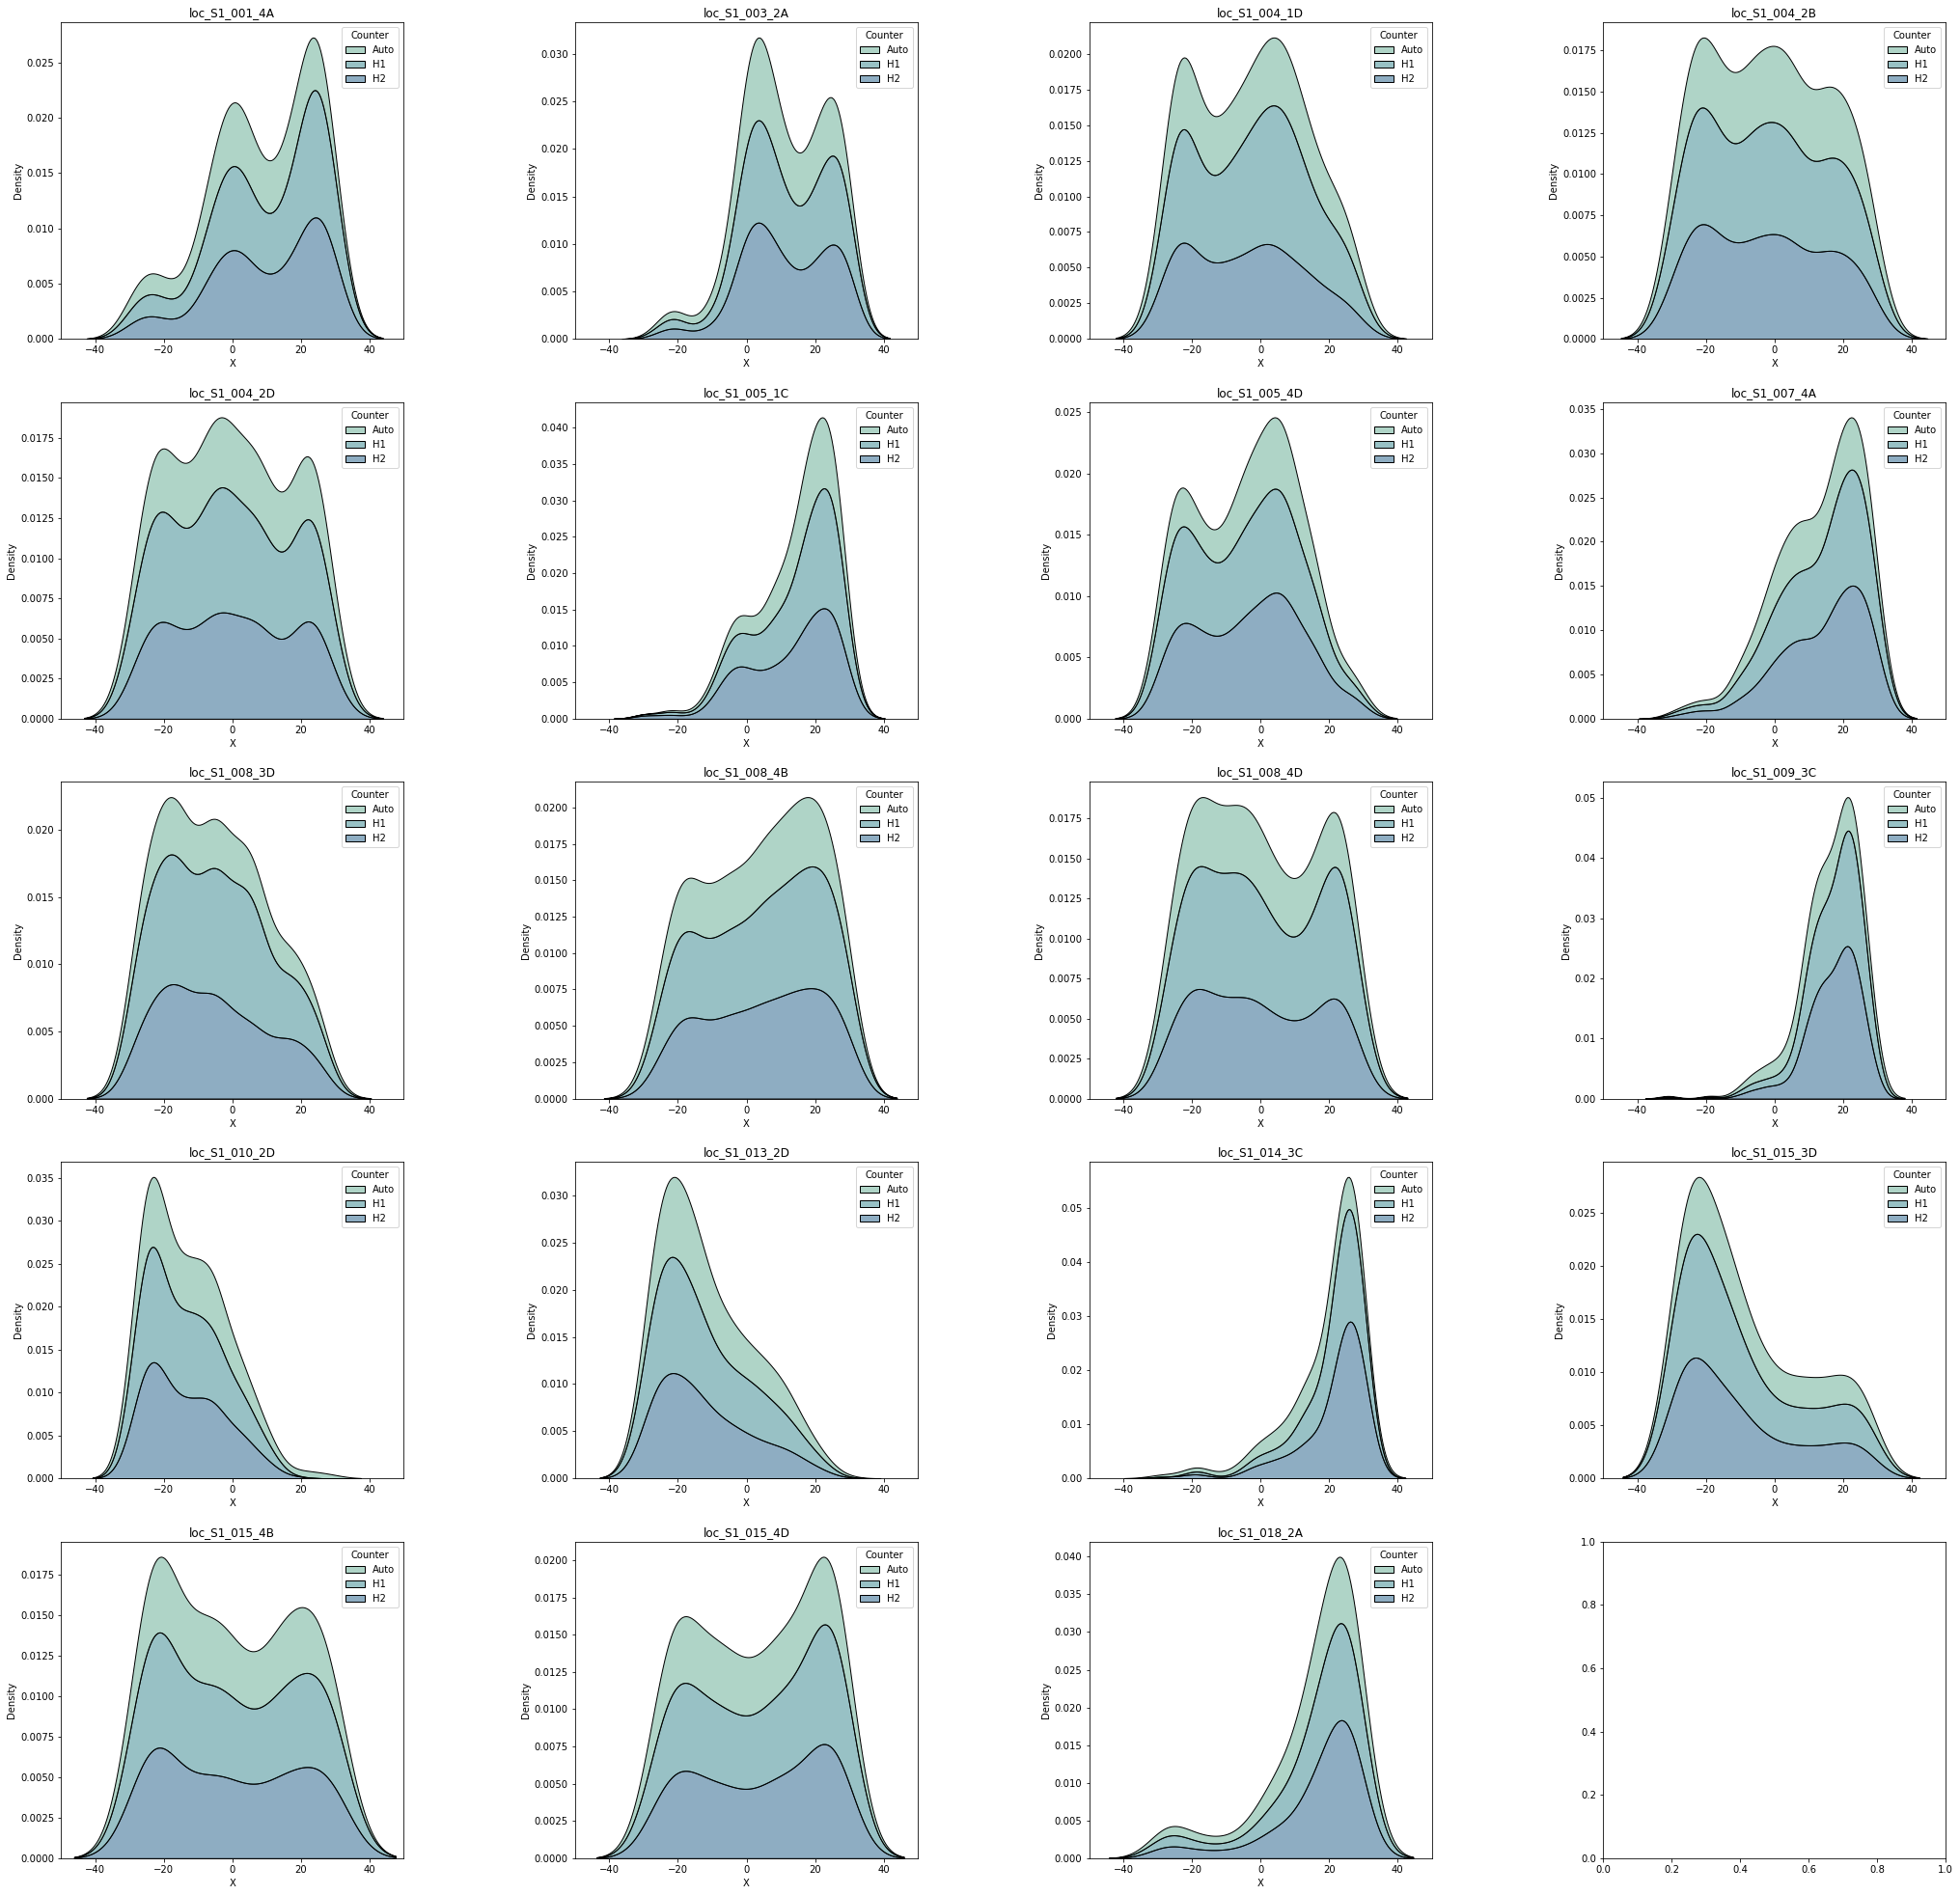

In [225]:
f, ax = plt.subplots(nrows=5, ncols=4,
                        figsize=(35, 35),
                        gridspec_kw={'wspace': 0.50}
                       )
i=0
for n, g in gcomb:
    fname = g['FileName'].unique()[0]
    #sns.displot(data=g, x="X", hue="Counter", kind="kde", label='FileName', fill=True, ax=ax.flat[i])
    sns.kdeplot(data=g, x="X", hue="Counter", fill=True, ax=ax.flat[i], multiple="stack", alpha=.5, palette="crest").set(title = fname,
    xlim = (-50,50))
    i += 1
    
plt.savefig('C:/Users/Emily/Desktop/UL_analysis/corrected_comparison.png', dpi=300)

             X Counter       FileName  Total
0   -22.935500    Auto  loc_S1_001_4A    305
1     0.792333    Auto  loc_S1_001_4A    305
2    -6.827667    Auto  loc_S1_001_4A    305
3    11.714333    Auto  loc_S1_001_4A    305
4     6.465000    Auto  loc_S1_001_4A    305
..         ...     ...            ...    ...
475  28.139667      H2  loc_S1_001_4A    305
476  28.711167      H2  loc_S1_001_4A    305
477  29.303833      H2  loc_S1_001_4A    305
478  29.621333      H2  loc_S1_001_4A    305
479  30.065833      H2  loc_S1_001_4A    305

[1250 rows x 4 columns]
             X Counter       FileName  Total
0     7.904333    Auto  loc_S1_003_2A    242
1    20.308000    Auto  loc_S1_003_2A    242
2     9.301333    Auto  loc_S1_003_2A    242
3     7.015333    Auto  loc_S1_003_2A    242
4    -9.833333    Auto  loc_S1_003_2A    242
..         ...     ...            ...    ...
345  27.123667      H2  loc_S1_003_2A    242
346  26.912000      H2  loc_S1_003_2A    242
347  27.631667      H2  loc_S1

             X Counter       FileName  Total
0    -2.636667    Auto  loc_S1_015_4B    183
1     6.380333    Auto  loc_S1_015_4B    183
2    24.456667    Auto  loc_S1_015_4B    183
3    13.407667    Auto  loc_S1_015_4B    183
4   -12.648500    Auto  loc_S1_015_4B    183
..         ...     ...            ...    ...
256  30.129333      H2  loc_S1_015_4B    183
257  30.129333      H2  loc_S1_015_4B    183
258  29.684833      H2  loc_S1_015_4B    183
259  30.997167      H2  loc_S1_015_4B    183
260  31.970833      H2  loc_S1_015_4B    183

[712 rows x 4 columns]
             X Counter       FileName  Total
0    25.303333    Auto  loc_S1_015_4D    245
1     9.068500    Auto  loc_S1_015_4D    245
2    -4.097167    Auto  loc_S1_015_4D    245
3    10.190333    Auto  loc_S1_015_4D    245
4    -9.981500    Auto  loc_S1_015_4D    245
..         ...     ...            ...    ...
340   8.073667      H2  loc_S1_015_4D    245
341   9.301333      H2  loc_S1_015_4D    245
342  10.126833      H2  loc_S1_

             X Counter       FileName  Total
0    25.303333    Auto  loc_S1_015_4D    245
1     9.068500    Auto  loc_S1_015_4D    245
2    -4.097167    Auto  loc_S1_015_4D    245
3    10.190333    Auto  loc_S1_015_4D    245
4    -9.981500    Auto  loc_S1_015_4D    245
..         ...     ...            ...    ...
340   8.073667      H2  loc_S1_015_4D    245
341   9.301333      H2  loc_S1_015_4D    245
342  10.126833      H2  loc_S1_015_4D    245
343  10.232667      H2  loc_S1_015_4D    245
344   8.221833      H2  loc_S1_015_4D    245

[948 rows x 4 columns]
             X Counter       FileName  Total
0    16.138167    Auto  loc_S1_018_2A    137
1     2.358667    Auto  loc_S1_018_2A    137
2    15.736000    Auto  loc_S1_018_2A    137
3    16.625000    Auto  loc_S1_018_2A    137
4    18.762833    Auto  loc_S1_018_2A    137
..         ...     ...            ...    ...
213  24.562500      H2  loc_S1_018_2A    137
214  28.880500      H2  loc_S1_018_2A    137
215  26.933167      H2  loc_S1_

[712 rows x 4 columns]
             X Counter       FileName  Total
0    25.303333    Auto  loc_S1_015_4D    245
1     9.068500    Auto  loc_S1_015_4D    245
2    -4.097167    Auto  loc_S1_015_4D    245
3    10.190333    Auto  loc_S1_015_4D    245
4    -9.981500    Auto  loc_S1_015_4D    245
..         ...     ...            ...    ...
340   8.073667      H2  loc_S1_015_4D    245
341   9.301333      H2  loc_S1_015_4D    245
342  10.126833      H2  loc_S1_015_4D    245
343  10.232667      H2  loc_S1_015_4D    245
344   8.221833      H2  loc_S1_015_4D    245

[948 rows x 4 columns]
             X Counter       FileName  Total
0    16.138167    Auto  loc_S1_018_2A    137
1     2.358667    Auto  loc_S1_018_2A    137
2    15.736000    Auto  loc_S1_018_2A    137
3    16.625000    Auto  loc_S1_018_2A    137
4    18.762833    Auto  loc_S1_018_2A    137
..         ...     ...            ...    ...
213  24.562500      H2  loc_S1_018_2A    137
214  28.880500      H2  loc_S1_018_2A    137
215  26.

             X Counter       FileName  Total
0    25.303333    Auto  loc_S1_015_4D    245
1     9.068500    Auto  loc_S1_015_4D    245
2    -4.097167    Auto  loc_S1_015_4D    245
3    10.190333    Auto  loc_S1_015_4D    245
4    -9.981500    Auto  loc_S1_015_4D    245
..         ...     ...            ...    ...
340   8.073667      H2  loc_S1_015_4D    245
341   9.301333      H2  loc_S1_015_4D    245
342  10.126833      H2  loc_S1_015_4D    245
343  10.232667      H2  loc_S1_015_4D    245
344   8.221833      H2  loc_S1_015_4D    245

[948 rows x 4 columns]
             X Counter       FileName  Total
0    16.138167    Auto  loc_S1_018_2A    137
1     2.358667    Auto  loc_S1_018_2A    137
2    15.736000    Auto  loc_S1_018_2A    137
3    16.625000    Auto  loc_S1_018_2A    137
4    18.762833    Auto  loc_S1_018_2A    137
..         ...     ...            ...    ...
213  24.562500      H2  loc_S1_018_2A    137
214  28.880500      H2  loc_S1_018_2A    137
215  26.933167      H2  loc_S1_

[414 rows x 4 columns]
             X Counter       FileName  Total
0     1.046333    Auto  loc_S1_015_3D    250
1    10.253833    Auto  loc_S1_015_3D    250
2    -0.816333    Auto  loc_S1_015_3D    250
3    13.873333    Auto  loc_S1_015_3D    250
4    17.768000    Auto  loc_S1_015_3D    250
..         ...     ...            ...    ...
403  -0.816333      H2  loc_S1_015_3D    250
404   3.184167      H2  loc_S1_015_3D    250
405   8.645167      H2  loc_S1_015_3D    250
406   6.570833      H2  loc_S1_015_3D    250
407  24.350833      H2  loc_S1_015_3D    250

[1086 rows x 4 columns]
             X Counter       FileName  Total
0    -2.636667    Auto  loc_S1_015_4B    183
1     6.380333    Auto  loc_S1_015_4B    183
2    24.456667    Auto  loc_S1_015_4B    183
3    13.407667    Auto  loc_S1_015_4B    183
4   -12.648500    Auto  loc_S1_015_4B    183
..         ...     ...            ...    ...
256  30.129333      H2  loc_S1_015_4B    183
257  30.129333      H2  loc_S1_015_4B    183
258  29

             X Counter       FileName  Total
0    -1.917000    Auto  loc_S1_009_3C    189
1    10.084500    Auto  loc_S1_009_3C    189
2    18.826333    Auto  loc_S1_009_3C    189
3     8.666333    Auto  loc_S1_009_3C    189
4    -0.922167    Auto  loc_S1_009_3C    189
..         ...     ...            ...    ...
457   8.031333      H2  loc_S1_009_3C    189
458  11.375667      H2  loc_S1_009_3C    189
459  12.264667      H2  loc_S1_009_3C    189
460  12.053000      H2  loc_S1_009_3C    189
461  13.428833      H2  loc_S1_009_3C    189

[999 rows x 4 columns]
             X Counter       FileName  Total
0   -14.193667    Auto  loc_S1_010_2D    198
1   -17.897833    Auto  loc_S1_010_2D    198
2   -20.861167    Auto  loc_S1_010_2D    198
3     6.232167    Auto  loc_S1_010_2D    198
4   -22.639167    Auto  loc_S1_010_2D    198
..         ...     ...            ...    ...
275   2.528000      H2  loc_S1_010_2D    198
276  -6.150333      H2  loc_S1_010_2D    198
277  -7.674333      H2  loc_S1_

             X Counter       FileName  Total
0   -23.676333    Auto  loc_S1_008_4D    372
1   -14.786333    Auto  loc_S1_008_4D    372
2   -17.728500    Auto  loc_S1_008_4D    372
3   -16.881833    Auto  loc_S1_008_4D    372
4   -16.818333    Auto  loc_S1_008_4D    372
..         ...     ...            ...    ...
572 -18.024833      H2  loc_S1_008_4D    372
573  -9.727500      H2  loc_S1_008_4D    372
574  -8.965500      H2  loc_S1_008_4D    372
575  -9.113667      H2  loc_S1_008_4D    372
576  -7.589667      H2  loc_S1_008_4D    372

[1628 rows x 4 columns]
             X Counter       FileName  Total
0    -1.917000    Auto  loc_S1_009_3C    189
1    10.084500    Auto  loc_S1_009_3C    189
2    18.826333    Auto  loc_S1_009_3C    189
3     8.666333    Auto  loc_S1_009_3C    189
4    -0.922167    Auto  loc_S1_009_3C    189
..         ...     ...            ...    ...
457   8.031333      H2  loc_S1_009_3C    189
458  11.375667      H2  loc_S1_009_3C    189
459  12.264667      H2  loc_S1

[1628 rows x 4 columns]
             X Counter       FileName  Total
0    -1.917000    Auto  loc_S1_009_3C    189
1    10.084500    Auto  loc_S1_009_3C    189
2    18.826333    Auto  loc_S1_009_3C    189
3     8.666333    Auto  loc_S1_009_3C    189
4    -0.922167    Auto  loc_S1_009_3C    189
..         ...     ...            ...    ...
457   8.031333      H2  loc_S1_009_3C    189
458  11.375667      H2  loc_S1_009_3C    189
459  12.264667      H2  loc_S1_009_3C    189
460  12.053000      H2  loc_S1_009_3C    189
461  13.428833      H2  loc_S1_009_3C    189

[999 rows x 4 columns]
             X Counter       FileName  Total
0   -14.193667    Auto  loc_S1_010_2D    198
1   -17.897833    Auto  loc_S1_010_2D    198
2   -20.861167    Auto  loc_S1_010_2D    198
3     6.232167    Auto  loc_S1_010_2D    198
4   -22.639167    Auto  loc_S1_010_2D    198
..         ...     ...            ...    ...
275   2.528000      H2  loc_S1_010_2D    198
276  -6.150333      H2  loc_S1_010_2D    198
277  -7

             X Counter       FileName  Total
0    -1.917000    Auto  loc_S1_009_3C    189
1    10.084500    Auto  loc_S1_009_3C    189
2    18.826333    Auto  loc_S1_009_3C    189
3     8.666333    Auto  loc_S1_009_3C    189
4    -0.922167    Auto  loc_S1_009_3C    189
..         ...     ...            ...    ...
457   8.031333      H2  loc_S1_009_3C    189
458  11.375667      H2  loc_S1_009_3C    189
459  12.264667      H2  loc_S1_009_3C    189
460  12.053000      H2  loc_S1_009_3C    189
461  13.428833      H2  loc_S1_009_3C    189

[999 rows x 4 columns]
             X Counter       FileName  Total
0   -14.193667    Auto  loc_S1_010_2D    198
1   -17.897833    Auto  loc_S1_010_2D    198
2   -20.861167    Auto  loc_S1_010_2D    198
3     6.232167    Auto  loc_S1_010_2D    198
4   -22.639167    Auto  loc_S1_010_2D    198
..         ...     ...            ...    ...
275   2.528000      H2  loc_S1_010_2D    198
276  -6.150333      H2  loc_S1_010_2D    198
277  -7.674333      H2  loc_S1_

             X Counter       FileName  Total
0    -1.917000    Auto  loc_S1_009_3C    189
1    10.084500    Auto  loc_S1_009_3C    189
2    18.826333    Auto  loc_S1_009_3C    189
3     8.666333    Auto  loc_S1_009_3C    189
4    -0.922167    Auto  loc_S1_009_3C    189
..         ...     ...            ...    ...
457   8.031333      H2  loc_S1_009_3C    189
458  11.375667      H2  loc_S1_009_3C    189
459  12.264667      H2  loc_S1_009_3C    189
460  12.053000      H2  loc_S1_009_3C    189
461  13.428833      H2  loc_S1_009_3C    189

[999 rows x 4 columns]
             X Counter       FileName  Total
0   -14.193667    Auto  loc_S1_010_2D    198
1   -17.897833    Auto  loc_S1_010_2D    198
2   -20.861167    Auto  loc_S1_010_2D    198
3     6.232167    Auto  loc_S1_010_2D    198
4   -22.639167    Auto  loc_S1_010_2D    198
..         ...     ...            ...    ...
275   2.528000      H2  loc_S1_010_2D    198
276  -6.150333      H2  loc_S1_010_2D    198
277  -7.674333      H2  loc_S1_

             X Counter       FileName  Total
0    20.943000    Auto  loc_S1_014_3C     83
1     0.623000    Auto  loc_S1_014_3C     83
2     1.744833    Auto  loc_S1_014_3C     83
3    17.619833    Auto  loc_S1_014_3C     83
4     6.401500    Auto  loc_S1_014_3C     83
..         ...     ...            ...    ...
189  13.788667      H2  loc_S1_014_3C     83
190 -16.797167      H2  loc_S1_014_3C     83
191 -19.464167      H2  loc_S1_014_3C     83
192 -20.628333      H2  loc_S1_014_3C     83
193 -28.650500      H2  loc_S1_014_3C     83

[414 rows x 4 columns]
             X Counter       FileName  Total
0     1.046333    Auto  loc_S1_015_3D    250
1    10.253833    Auto  loc_S1_015_3D    250
2    -0.816333    Auto  loc_S1_015_3D    250
3    13.873333    Auto  loc_S1_015_3D    250
4    17.768000    Auto  loc_S1_015_3D    250
..         ...     ...            ...    ...
403  -0.816333      H2  loc_S1_015_3D    250
404   3.184167      H2  loc_S1_015_3D    250
405   8.645167      H2  loc_S1_

             X Counter       FileName  Total
0   -23.676333    Auto  loc_S1_008_4D    372
1   -14.786333    Auto  loc_S1_008_4D    372
2   -17.728500    Auto  loc_S1_008_4D    372
3   -16.881833    Auto  loc_S1_008_4D    372
4   -16.818333    Auto  loc_S1_008_4D    372
..         ...     ...            ...    ...
572 -18.024833      H2  loc_S1_008_4D    372
573  -9.727500      H2  loc_S1_008_4D    372
574  -8.965500      H2  loc_S1_008_4D    372
575  -9.113667      H2  loc_S1_008_4D    372
576  -7.589667      H2  loc_S1_008_4D    372

[1628 rows x 4 columns]
             X Counter       FileName  Total
0    -1.917000    Auto  loc_S1_009_3C    189
1    10.084500    Auto  loc_S1_009_3C    189
2    18.826333    Auto  loc_S1_009_3C    189
3     8.666333    Auto  loc_S1_009_3C    189
4    -0.922167    Auto  loc_S1_009_3C    189
..         ...     ...            ...    ...
457   8.031333      H2  loc_S1_009_3C    189
458  11.375667      H2  loc_S1_009_3C    189
459  12.264667      H2  loc_S1

             X Counter       FileName  Total
0   -14.193667    Auto  loc_S1_010_2D    198
1   -17.897833    Auto  loc_S1_010_2D    198
2   -20.861167    Auto  loc_S1_010_2D    198
3     6.232167    Auto  loc_S1_010_2D    198
4   -22.639167    Auto  loc_S1_010_2D    198
..         ...     ...            ...    ...
275   2.528000      H2  loc_S1_010_2D    198
276  -6.150333      H2  loc_S1_010_2D    198
277  -7.674333      H2  loc_S1_010_2D    198
278   9.597667      H2  loc_S1_010_2D    198
279  18.657000      H2  loc_S1_010_2D    198

[754 rows x 4 columns]
             X Counter       FileName  Total
0   -24.565333    Auto  loc_S1_013_2D    178
1   -15.781167    Auto  loc_S1_013_2D    178
2     1.808333    Auto  loc_S1_013_2D    178
3   -13.579833    Auto  loc_S1_013_2D    178
4    19.228500    Auto  loc_S1_013_2D    178
..         ...     ...            ...    ...
217  -1.536000      H2  loc_S1_013_2D    178
218  -2.636667      H2  loc_S1_013_2D    178
219  -5.092000      H2  loc_S1_

             X Counter       FileName  Total
0   -24.565333    Auto  loc_S1_013_2D    178
1   -15.781167    Auto  loc_S1_013_2D    178
2     1.808333    Auto  loc_S1_013_2D    178
3   -13.579833    Auto  loc_S1_013_2D    178
4    19.228500    Auto  loc_S1_013_2D    178
..         ...     ...            ...    ...
217  -1.536000      H2  loc_S1_013_2D    178
218  -2.636667      H2  loc_S1_013_2D    178
219  -5.092000      H2  loc_S1_013_2D    178
220  -5.134333      H2  loc_S1_013_2D    178
221  -6.489000      H2  loc_S1_013_2D    178

[645 rows x 4 columns]
             X Counter       FileName  Total
0    20.943000    Auto  loc_S1_014_3C     83
1     0.623000    Auto  loc_S1_014_3C     83
2     1.744833    Auto  loc_S1_014_3C     83
3    17.619833    Auto  loc_S1_014_3C     83
4     6.401500    Auto  loc_S1_014_3C     83
..         ...     ...            ...    ...
189  13.788667      H2  loc_S1_014_3C     83
190 -16.797167      H2  loc_S1_014_3C     83
191 -19.464167      H2  loc_S1_

             X Counter       FileName  Total
0    20.943000    Auto  loc_S1_014_3C     83
1     0.623000    Auto  loc_S1_014_3C     83
2     1.744833    Auto  loc_S1_014_3C     83
3    17.619833    Auto  loc_S1_014_3C     83
4     6.401500    Auto  loc_S1_014_3C     83
..         ...     ...            ...    ...
189  13.788667      H2  loc_S1_014_3C     83
190 -16.797167      H2  loc_S1_014_3C     83
191 -19.464167      H2  loc_S1_014_3C     83
192 -20.628333      H2  loc_S1_014_3C     83
193 -28.650500      H2  loc_S1_014_3C     83

[414 rows x 4 columns]
             X Counter       FileName  Total
0     1.046333    Auto  loc_S1_015_3D    250
1    10.253833    Auto  loc_S1_015_3D    250
2    -0.816333    Auto  loc_S1_015_3D    250
3    13.873333    Auto  loc_S1_015_3D    250
4    17.768000    Auto  loc_S1_015_3D    250
..         ...     ...            ...    ...
403  -0.816333      H2  loc_S1_015_3D    250
404   3.184167      H2  loc_S1_015_3D    250
405   8.645167      H2  loc_S1_

             X Counter       FileName  Total
0     1.046333    Auto  loc_S1_015_3D    250
1    10.253833    Auto  loc_S1_015_3D    250
2    -0.816333    Auto  loc_S1_015_3D    250
3    13.873333    Auto  loc_S1_015_3D    250
4    17.768000    Auto  loc_S1_015_3D    250
..         ...     ...            ...    ...
403  -0.816333      H2  loc_S1_015_3D    250
404   3.184167      H2  loc_S1_015_3D    250
405   8.645167      H2  loc_S1_015_3D    250
406   6.570833      H2  loc_S1_015_3D    250
407  24.350833      H2  loc_S1_015_3D    250

[1086 rows x 4 columns]
             X Counter       FileName  Total
0    -2.636667    Auto  loc_S1_015_4B    183
1     6.380333    Auto  loc_S1_015_4B    183
2    24.456667    Auto  loc_S1_015_4B    183
3    13.407667    Auto  loc_S1_015_4B    183
4   -12.648500    Auto  loc_S1_015_4B    183
..         ...     ...            ...    ...
256  30.129333      H2  loc_S1_015_4B    183
257  30.129333      H2  loc_S1_015_4B    183
258  29.684833      H2  loc_S1

             X Counter       FileName  Total
0   -14.193667    Auto  loc_S1_010_2D    198
1   -17.897833    Auto  loc_S1_010_2D    198
2   -20.861167    Auto  loc_S1_010_2D    198
3     6.232167    Auto  loc_S1_010_2D    198
4   -22.639167    Auto  loc_S1_010_2D    198
..         ...     ...            ...    ...
275   2.528000      H2  loc_S1_010_2D    198
276  -6.150333      H2  loc_S1_010_2D    198
277  -7.674333      H2  loc_S1_010_2D    198
278   9.597667      H2  loc_S1_010_2D    198
279  18.657000      H2  loc_S1_010_2D    198

[754 rows x 4 columns]
             X Counter       FileName  Total
0   -24.565333    Auto  loc_S1_013_2D    178
1   -15.781167    Auto  loc_S1_013_2D    178
2     1.808333    Auto  loc_S1_013_2D    178
3   -13.579833    Auto  loc_S1_013_2D    178
4    19.228500    Auto  loc_S1_013_2D    178
..         ...     ...            ...    ...
217  -1.536000      H2  loc_S1_013_2D    178
218  -2.636667      H2  loc_S1_013_2D    178
219  -5.092000      H2  loc_S1_

             X Counter       FileName  Total
0   -14.193667    Auto  loc_S1_010_2D    198
1   -17.897833    Auto  loc_S1_010_2D    198
2   -20.861167    Auto  loc_S1_010_2D    198
3     6.232167    Auto  loc_S1_010_2D    198
4   -22.639167    Auto  loc_S1_010_2D    198
..         ...     ...            ...    ...
275   2.528000      H2  loc_S1_010_2D    198
276  -6.150333      H2  loc_S1_010_2D    198
277  -7.674333      H2  loc_S1_010_2D    198
278   9.597667      H2  loc_S1_010_2D    198
279  18.657000      H2  loc_S1_010_2D    198

[754 rows x 4 columns]
             X Counter       FileName  Total
0   -24.565333    Auto  loc_S1_013_2D    178
1   -15.781167    Auto  loc_S1_013_2D    178
2     1.808333    Auto  loc_S1_013_2D    178
3   -13.579833    Auto  loc_S1_013_2D    178
4    19.228500    Auto  loc_S1_013_2D    178
..         ...     ...            ...    ...
217  -1.536000      H2  loc_S1_013_2D    178
218  -2.636667      H2  loc_S1_013_2D    178
219  -5.092000      H2  loc_S1_

             X Counter       FileName  Total
0   -14.193667    Auto  loc_S1_010_2D    198
1   -17.897833    Auto  loc_S1_010_2D    198
2   -20.861167    Auto  loc_S1_010_2D    198
3     6.232167    Auto  loc_S1_010_2D    198
4   -22.639167    Auto  loc_S1_010_2D    198
..         ...     ...            ...    ...
275   2.528000      H2  loc_S1_010_2D    198
276  -6.150333      H2  loc_S1_010_2D    198
277  -7.674333      H2  loc_S1_010_2D    198
278   9.597667      H2  loc_S1_010_2D    198
279  18.657000      H2  loc_S1_010_2D    198

[754 rows x 4 columns]
             X Counter       FileName  Total
0   -24.565333    Auto  loc_S1_013_2D    178
1   -15.781167    Auto  loc_S1_013_2D    178
2     1.808333    Auto  loc_S1_013_2D    178
3   -13.579833    Auto  loc_S1_013_2D    178
4    19.228500    Auto  loc_S1_013_2D    178
..         ...     ...            ...    ...
217  -1.536000      H2  loc_S1_013_2D    178
218  -2.636667      H2  loc_S1_013_2D    178
219  -5.092000      H2  loc_S1_

             X Counter       FileName  Total
0    -8.457500    Auto  loc_S1_008_4B    366
1    -0.583500    Auto  loc_S1_008_4B    366
2   -16.966500    Auto  loc_S1_008_4B    366
3   -20.967000    Auto  loc_S1_008_4B    366
4     5.216167    Auto  loc_S1_008_4B    366
..         ...     ...            ...    ...
579  -8.923167      H2  loc_S1_008_4B    366
580 -14.172500      H2  loc_S1_008_4B    366
581 -13.558667      H2  loc_S1_008_4B    366
582 -14.892167      H2  loc_S1_008_4B    366
583  21.218167      H2  loc_S1_008_4B    366

[1577 rows x 4 columns]
             X Counter       FileName  Total
0   -23.676333    Auto  loc_S1_008_4D    372
1   -14.786333    Auto  loc_S1_008_4D    372
2   -17.728500    Auto  loc_S1_008_4D    372
3   -16.881833    Auto  loc_S1_008_4D    372
4   -16.818333    Auto  loc_S1_008_4D    372
..         ...     ...            ...    ...
572 -18.024833      H2  loc_S1_008_4D    372
573  -9.727500      H2  loc_S1_008_4D    372
574  -8.965500      H2  loc_S1

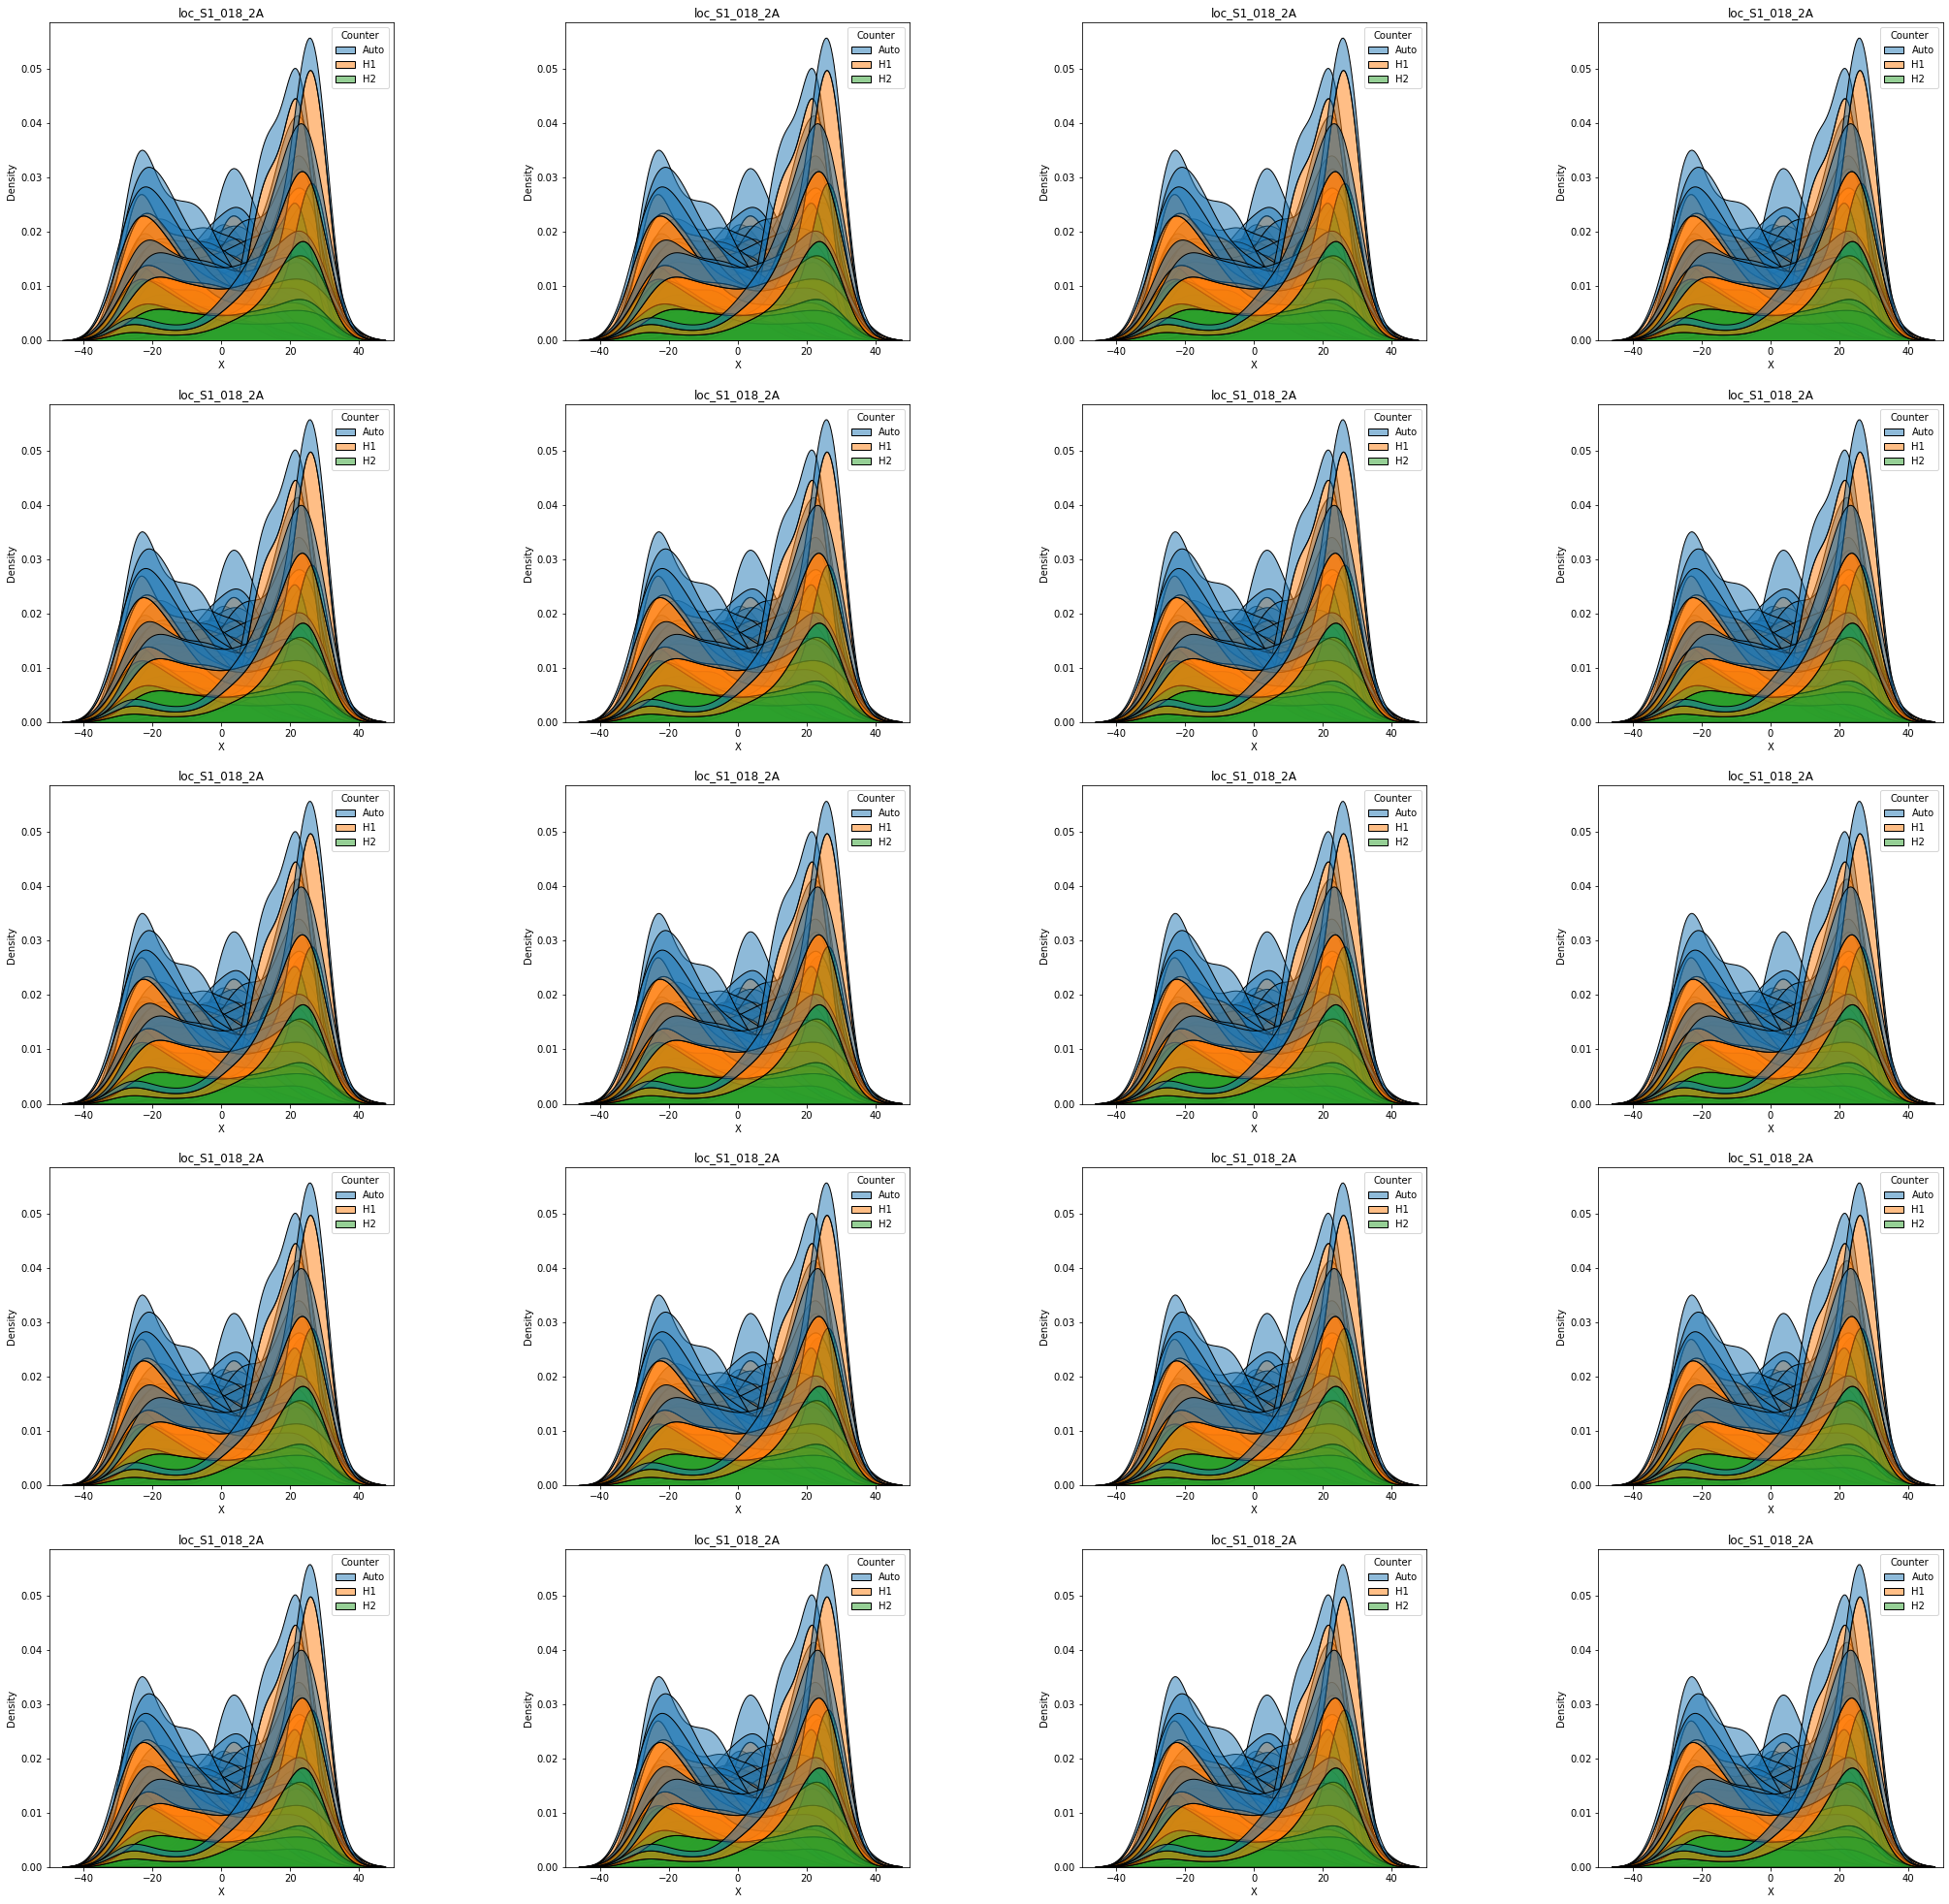

In [208]:
f, ax = plt.subplots(nrows=5, ncols=4,
                        figsize=(35, 35),
                        gridspec_kw={'wspace': 0.50} # ensure proper width-wise spacing.
                    )


for i in range(0,5):
    for j in range(0,4):
        for n, g in gcomb:
            fname = g['FileName'].unique()[0]
            print(g)
            #sns.displot(data=g, x="X", hue="Counter", kind="kde", label='FileName', fill=True, ax=ax.flat[i])
            sns.kdeplot(data=g, x="X", hue="Counter", fill=True,  multiple="stack", alpha=.5, ax=ax[i,j]).set(title = fname,
            xlim = (-50,50))


In [135]:
types = ['H1', 'H2']
cohend_df = pd.DataFrame()
for n, g in gcomb:
    analysis = dabest.load(g, idx=("Auto", "H1", "H2"), x="Counter", y="X")
    ad = analysis.cohens_d.statistical_tests
    #ad.cohens_d.plot()
    
    ad['FileName'] = n
    
    auto = g.loc[g['Counter'] == 'Auto']['X']
    for t in types:
        if t == 'H1' :
            h1 = g.loc[g['Counter'] == 'H1']['X']
            cohens_d = -(mean(auto) - mean(h1)) / (sqrt((stdev(auto) ** 2 + stdev(h1) ** 2) / 2))
            ad.loc[ad['test'] =='H1', ['Cohens_d']] = cohens_d

        elif t == 'H2':
            h2 = g.loc[g['Counter'] == 'H2']['X']
            cohens_d = -(mean(auto) - mean(h2)) / (sqrt((stdev(auto) ** 2 + stdev(h2) ** 2) / 2))
            ad.loc[ad['test'] =='H2', ['Cohens_d']] = cohens_d
        
    cohend_df = cohend_df.append(ad, ignore_index = True)

print(len(cohend_df))

C:\ProgramData\Anaconda3\envs\neuroplant\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\ProgramData\Anaconda3\envs\neuroplant\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\ProgramData\Anaconda3\envs\neuroplant\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

C:\ProgramData\Anaconda3\envs\neuroplant\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\ProgramData\Anaconda3\envs\neuroplant\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\ProgramData\Anaconda3\envs\neuroplant\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

38


C:\ProgramData\Anaconda3\envs\neuroplant\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\ProgramData\Anaconda3\envs\neuroplant\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [136]:
cohend_df = cohend_df.drop(columns=['is_paired', 'ci', 'pvalue_permutation', 'pvalue_welch', 'statistic_welch', 'pvalue_students_t', 'statistic_students_t',
                                   'pvalue_mann_whitney', 'statistic_mann_whitney'])
cohend_df.head()

control test  control_N  test_N effect_size  difference   bca_low  bca_high  \
0    Auto   H1        305     465   Cohen's d    0.308336  0.159069  0.453426   
1    Auto   H2        305     480   Cohen's d    0.288188  0.144025  0.428150   
2    Auto   H1        242     318   Cohen's d    0.143698 -0.025538  0.310034   
3    Auto   H2        242     350   Cohen's d    0.136045 -0.027426  0.296870   
4    Auto   H1        353     602   Cohen's d    0.067051 -0.064607  0.202442   

        FileName  Cohens_d  
0  loc_S1_001_4A  0.309006  
1  loc_S1_001_4A  0.289038  
2  loc_S1_003_2A  0.144000  
3  loc_S1_003_2A  0.136410  
4  loc_S1_004_1D  0.066695

In [227]:
cohend_df.to_csv('C:/Users/Emily/Desktop/UL_analysis/cohens_d.csv')

loc_S1_001_4A
loc_S1_003_2A
loc_S1_004_1D
loc_S1_004_2B
loc_S1_004_2D
loc_S1_005_1C
loc_S1_005_4D
loc_S1_007_4A
loc_S1_008_3D
loc_S1_008_4B
loc_S1_008_4D
loc_S1_009_3C
loc_S1_010_2D
loc_S1_013_2D
loc_S1_014_3C
loc_S1_015_3D
loc_S1_015_4B
loc_S1_015_4D
loc_S1_018_2A


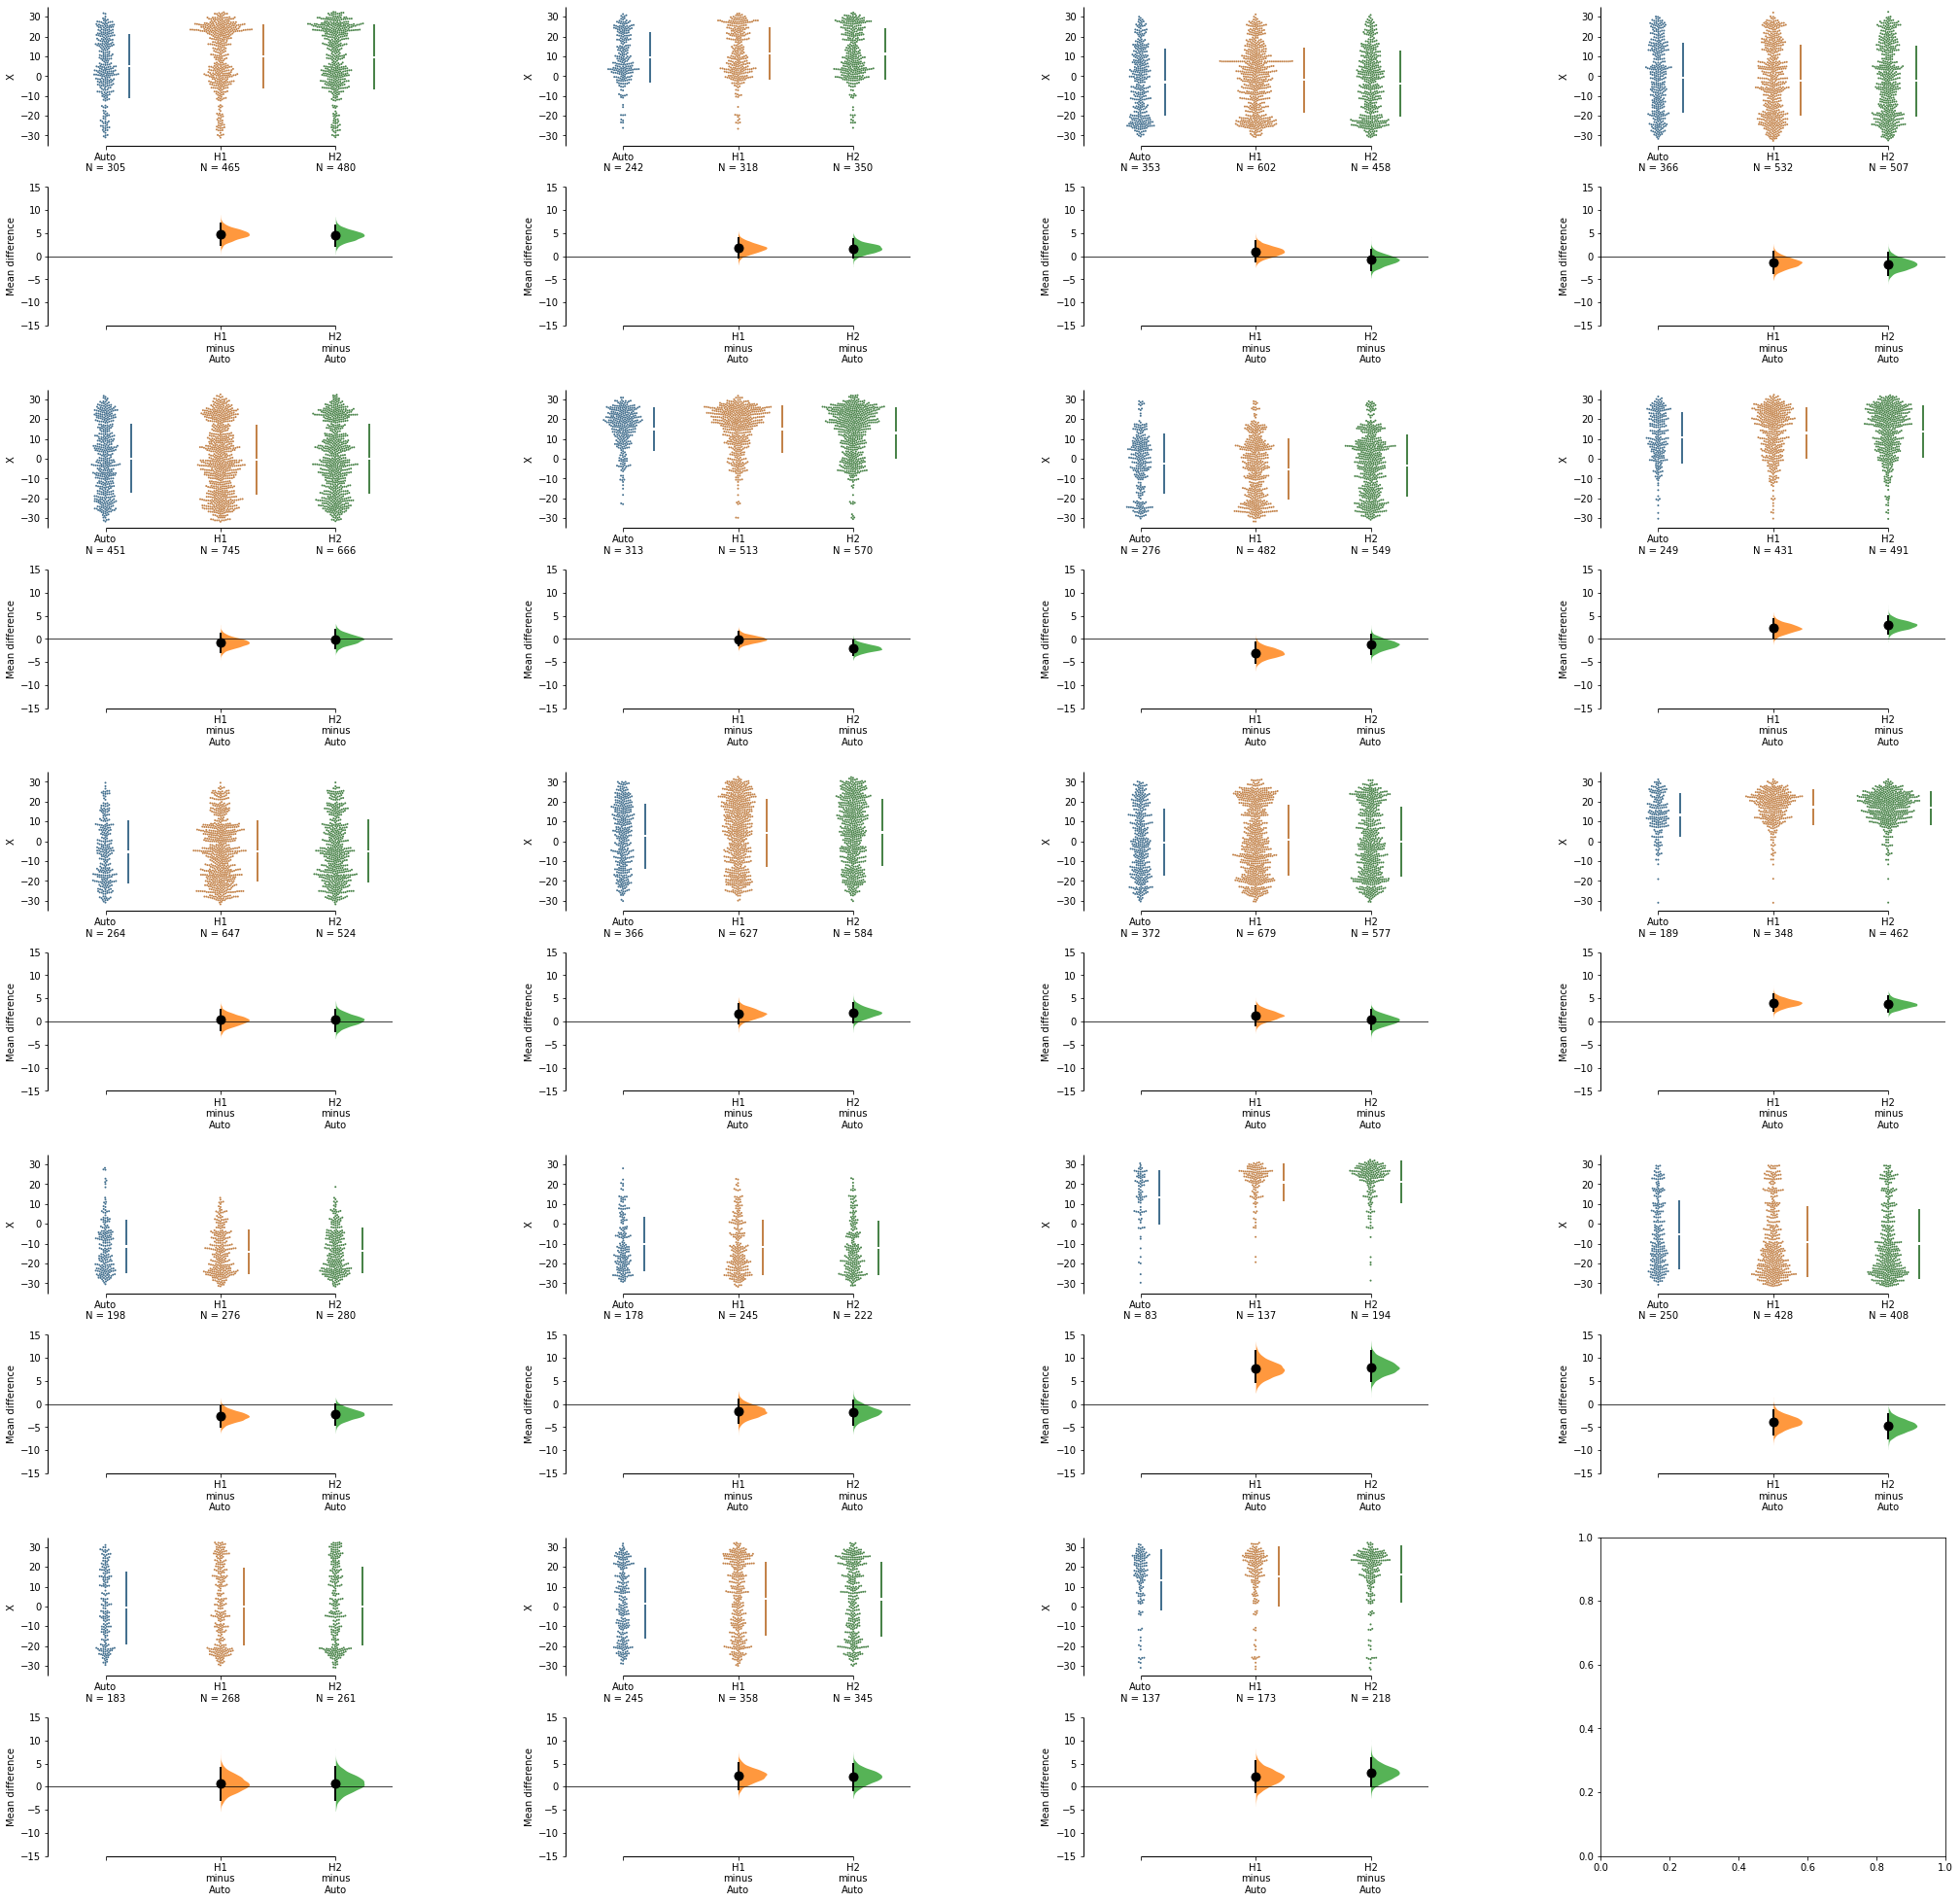

In [245]:
f, axx = plt.subplots(nrows=5, ncols=4,
                        figsize=(35, 35),
                        gridspec_kw={'wspace': 0.50} # ensure proper width-wise spacing.
                       )
i=0
for n, g in gcomb:
    fname = g['FileName'].unique()[0]
    multi = dabest.load(g, idx=(("Auto", "H1", "H2")), x="Counter", y="X")
    multi.mean_diff.plot(ax=axx.flat[i], raw_marker_size=2, contrast_ylim=(-15,15), swarm_ylim=(-35,35))
    i += 1
plt.savefig('C:/Users/Emily/Desktop/UL_analysis/UL_mean_diff.png', dpi=300)

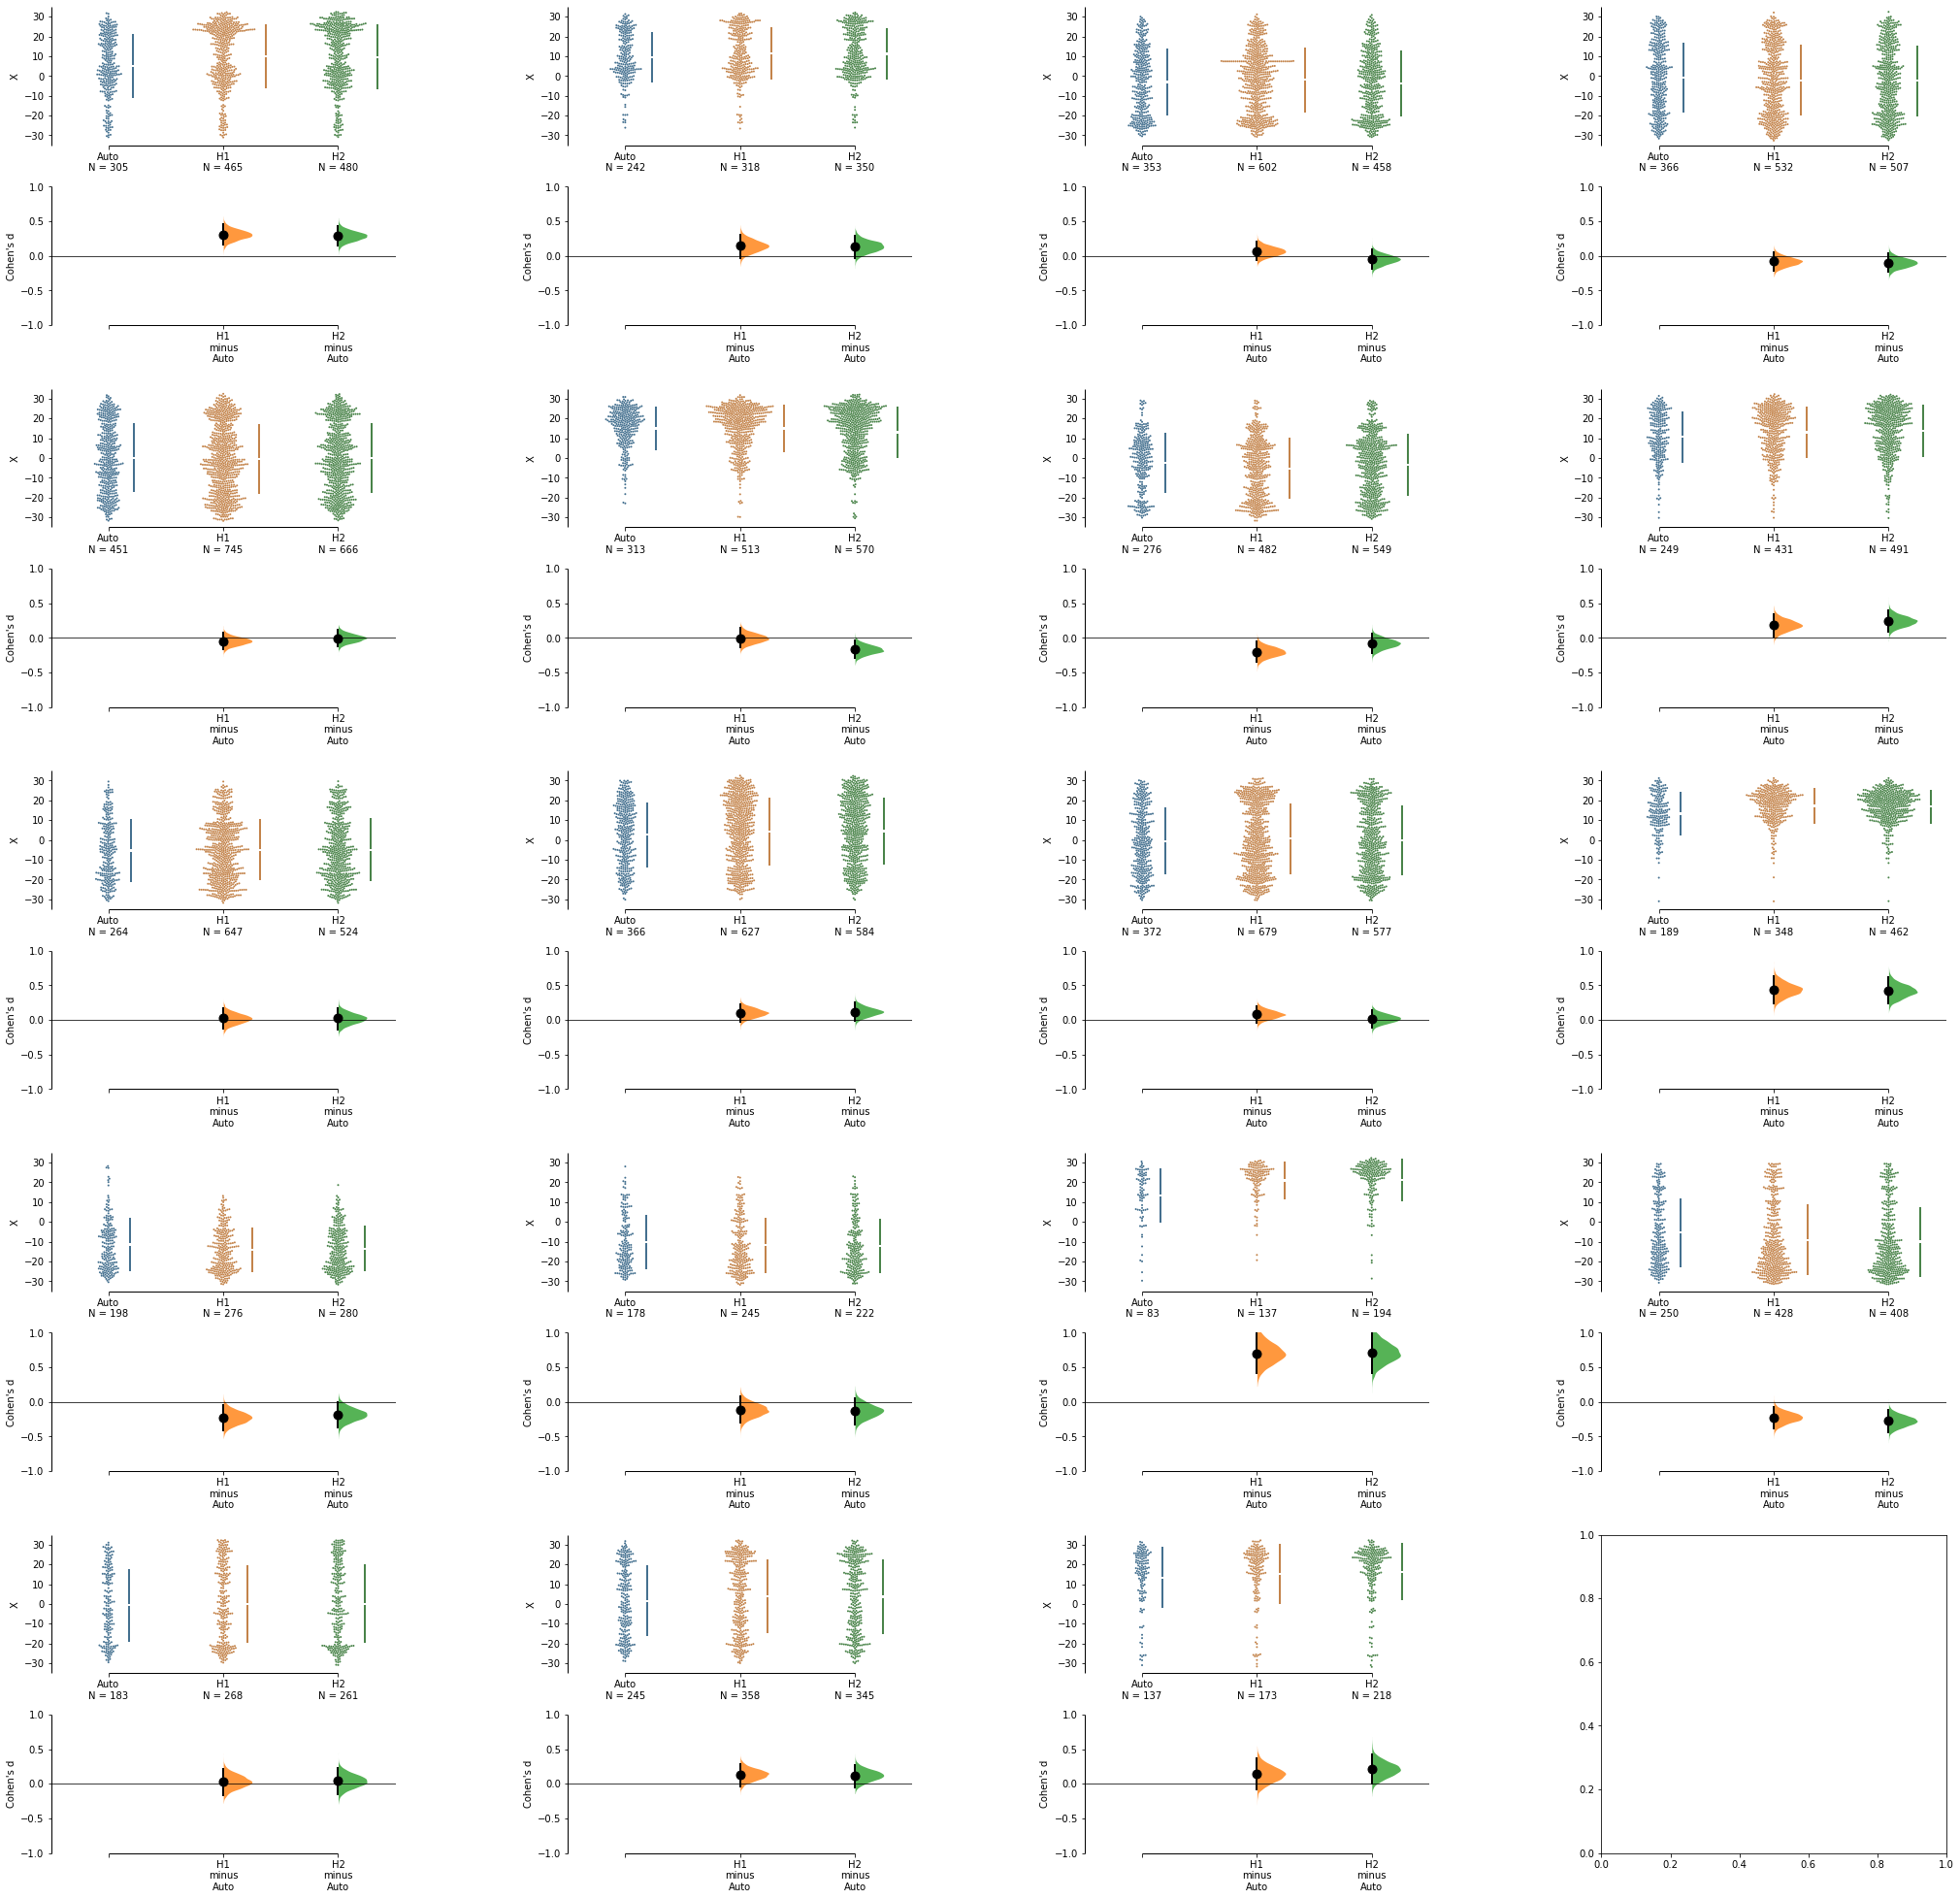

In [134]:
f, axx = plt.subplots(nrows=5, ncols=4,
                        figsize=(35, 35),
                        gridspec_kw={'wspace': 0.50} # ensure proper width-wise spacing.
                       )
i=0
for n, g in gcomb:
    multi = dabest.load(g, idx=(("Auto", "H1", "H2")), x="Counter", y="X")
    multi.cohens_d.plot(ax=axx.flat[i], raw_marker_size=2, contrast_ylim=(-1,1), swarm_ylim=(-35,35))
    i += 1

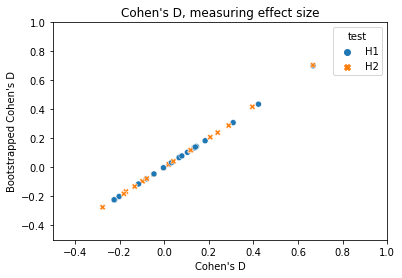

In [246]:
fig, ax = plt.subplots()
ax = sns.scatterplot(data=cohend_df, x="Cohens_d", y="difference", hue="test", style="test")
ax.set_xlabel('Cohen\'s D')
ax.set_ylabel('Bootstrapped Cohen\'s D')
ax.set(ylim=(-.5,1), xlim=(-.5,1), title='Cohen\'s D, measuring effect size')
plt.savefig('C:/Users/Emily/Desktop/UL_analysis/comparing_cds.png', dpi=300)

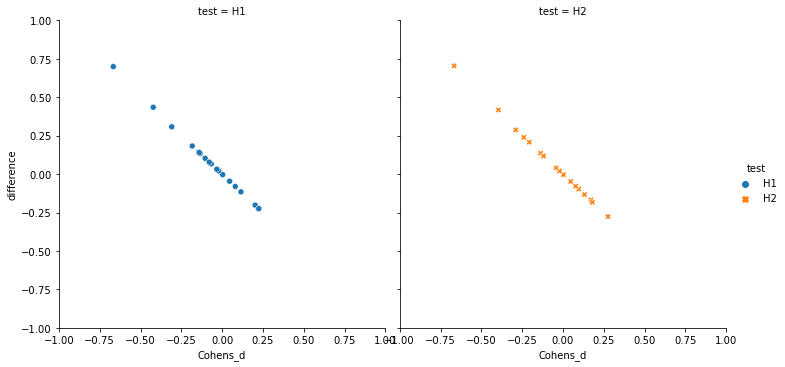

In [121]:
p = sns.relplot(
    data=cohend_df, x="Cohens_d", y="difference",
    col="test", hue="test", style="test",
    kind="scatter"
)
p.set(ylim=(-1, 1), xlim=(-1,1))